# Install dan Import Library

In [1]:
! pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


In [2]:
# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Flatten, GRU, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Pemrosesan teks
import string
import re
import json
import requests
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_download
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
nltk_download('punkt')
nltk_download('punkt_tab')
nltk_download('stopwords')

# Manipulasi dataset dan visualisasi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Pelatihan Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Dataset

In [3]:
import pandas as pd
data = "/content/tokopedia_app_reviews.csv"
df = pd.read_csv(data)


In [4]:
df.head()

,text,score
0,baguss sekali,5
1,cool,5
2,"promonya hanya waktu tertentu saja, recommend ...",5
3,aplikasi tidak jelasssss,1
4,Emang tokopedia gak ada dana ya buat hire cust...,1


# Exploraroty Data Analysis (EDA)

In [5]:
# Overview dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    19999 non-null  object
 1   score   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 312.6+ KB


In [6]:
# Check missing value
print(df.isnull().sum())

text     1
score    0
dtype: int64


In [7]:
# Drop Missing value
df= df.dropna()
print(df.isnull().sum())

text     0
score    0
dtype: int64


<ipython-input-8-cbb6b67072bb>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['score'], palette='Reds')


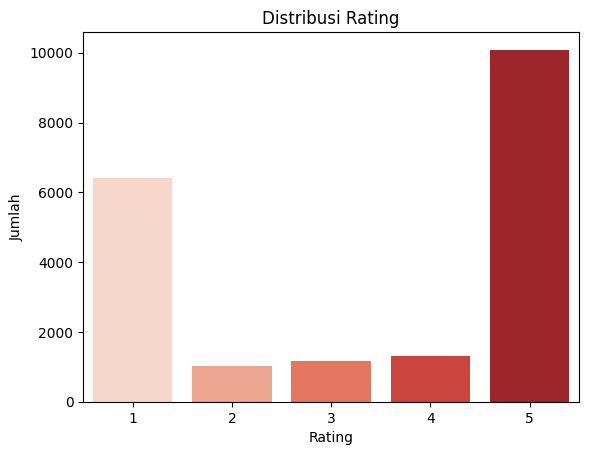

score
5    10087
1     6404
4     1300
3     1171
2     1037
Name: count, dtype: int64


In [8]:
# Rating distribution
sns.countplot(x=df['score'], palette='Reds')
plt.title("Distribusi Rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah")
plt.show()

print(df['score'].value_counts())

Pada aplikasi tokopedia, pengguna banyak memberikan rating 5 pada aplikasi namun juga memberikan rating 1 sebagai tanda kurangnya kepuasan.

# Text Processing

In [9]:
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import json

# Pembersihan teks
def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Menghapus @mention
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Menghapus #hashtag
    text = re.sub(r'\d+', ' ', text)  # Menghapus angka
    text = re.sub(r'[²]', ' ', text)  # Menghapus karakter khusus
    text = re.sub(r'[^\w\s]', ' ', text)  # Menghapus tanda baca
    text = text.strip()
    return text

# Tokenisasi teks
def token_text(text):
    return word_tokenize(text)

# Menghapus stopwords
def remove_stopwords_text(text):
    stopwords_ind = set(stopwords.words('indonesian'))
    stopwords_eng = set(stopwords.words('english'))
    listStopwords = stopwords_ind.union(stopwords_eng)
    listStopwords.update(['iya', 'yaa', 'gak', 'nya', 'na', 'sih', 'ku', 'di', 'ga', 'ya', 'gaa', 'loh', 'kah', 'woi', 'woii', 'woy'
    , 'gk', 'tokped', 'tokopedia', 'bagu','udh'])

    # Pastikan text sudah berupa token
    if isinstance(text, str):
        text = word_tokenize(text)

    removed = [txt for txt in text if txt not in listStopwords]
    return removed

# Normalisasi slangwords
def load_slangwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        slang_words = json.load(file)
    return slang_words

def norm_slangwords(text, slangwords):
    words = text.split()
    norm_words = [slangwords[word.lower()] if word.lower() in slangwords else word for word in words]
    return ' '.join(norm_words)
slangwords = load_slangwords('/content/slangwords.json')
# Proses keseluruhan
df['clean_text'] = df['text'].apply(cleaning_text)
df['text_slangwords'] = df['clean_text'].apply(lambda x: norm_slangwords(x, slangwords))
df['text_tokenizing'] = df['text_slangwords'].apply(token_text)
df['text_stopword'] = df['text_tokenizing'].apply(remove_stopwords_text)
df['clean_content'] = df['text_stopword'].apply(lambda x: ' '.join(x))


In [10]:
import requests

# Fungsi untuk mendapatkan data lexicon
def get_lexicon_data(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        lexicon = {line.strip() for line in response.text.splitlines() if line.strip()}
        return lexicon
    except requests.exceptions.RequestException as error:
        print(f"Error accessing {url}: {error}")
        return set()

# URLs for positive and negative lexicons
positive_url = "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/positive.txt"
negative_url = "https://raw.githubusercontent.com/masdevid/ID-OpinionWords/master/negative.txt"

# Fetch positive and negative lexicons
positive_words = get_lexicon_data(positive_url)
negative_words = get_lexicon_data(negative_url)

# Display statistics
print(f"Jumlah Kata Positif: {len(positive_words)}")
print(f"Jumlah Kata Negatif: {len(negative_words)}")

# Fungsi untuk analisis sentimen
def analyze_sentiment(text):
    positive_count = 0
    negative_count = 0

    # Hitung jumlah kata positif dan negatif dalam teks
    for word in text:
        if word in positive_words:
            positive_count += 1
        elif word in negative_words:
            negative_count += 1

    # Tentukan skor sentimen
    sentiment_score = positive_count - negative_count

    # Tentukan label sentimen
    if sentiment_score > 0:
        sentiment_label = 'positive'
    elif sentiment_score < 0:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'

    return sentiment_score, sentiment_label

# Aplikasi Sentimen
def apply_sentiment_analysis(text_column):
    sentiment_scores = []
    sentiment_labels = []

    for text in text_column:
        # Pastikan text sudah dalam bentuk token (list kata)
        if isinstance(text, str):
            text = text.split()  # Tokenisasi jika diperlukan
        score, label = analyze_sentiment(text)
        sentiment_scores.append(score)
        sentiment_labels.append(label)

    return sentiment_scores, sentiment_labels

# Terapkan analisis sentimen
scores, labels = apply_sentiment_analysis(df['text_stopword'])

# Tambahkan hasil ke DataFrame
df['sentiment_score'] = scores
df['sentiment'] = labels

# Hitung jumlah sentimen
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


Jumlah Kata Positif: 1182
Jumlah Kata Negatif: 2402
sentiment
neutral     9469
positive    7141
negative    3389
Name: count, dtype: int64


<ipython-input-11-075a61d8fa31>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_df, x='Sentiment', y='Count', palette='Reds')


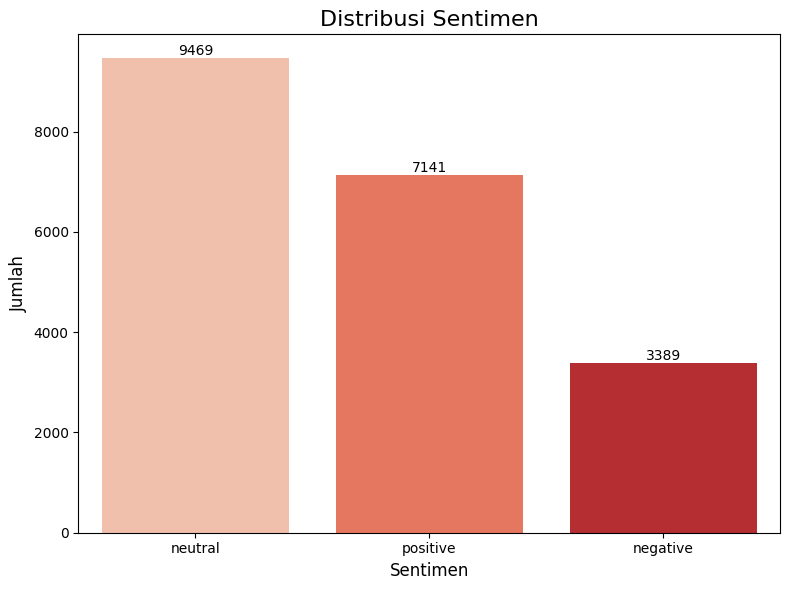

In [11]:
# Distribusi Kelas Sentimen
def plot_sentiment_distribution(sentiment_counts):
    sentiment_df = sentiment_counts.reset_index()
    sentiment_df.columns = ['Sentiment', 'Count']
    plt.figure(figsize=(8, 6))
    sns.barplot(data=sentiment_df, x='Sentiment', y='Count', palette='Reds')
    plt.title('Distribusi Sentimen', fontsize=16)
    plt.xlabel('Sentimen', fontsize=12)
    plt.ylabel('Jumlah', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    for index, row in sentiment_df.iterrows():
        plt.text(row.name, row['Count'], f"{row['Count']}", ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()
plot_sentiment_distribution(sentiment_counts)


Descriptive Statistics for Text Length:
count    19999.000000
mean         6.861093
std          8.148444
min          0.000000
25%          1.000000
50%          4.000000
75%          9.000000
max         83.000000
Name: text_length, dtype: float64


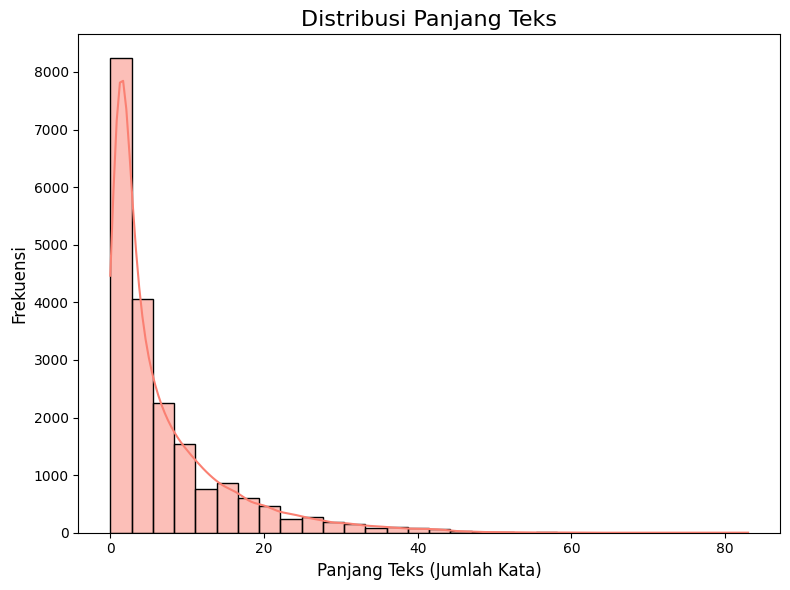

In [12]:
# Menambahkan kolom panjang teks ke DataFrame
df['text_length'] = df['text_stopword'].apply(lambda x: len(x))

# Deskriptif statistik panjang teks
print("Descriptive Statistics for Text Length:")
print(df['text_length'].describe())

# Membuat histogram panjang teks
def plot_text_length_distribution(df):
    plt.figure(figsize=(8, 6))

    # Membuat histogram menggunakan Seaborn
    sns.histplot(df['text_length'], bins=30, kde=True, color='salmon')

    # Menambahkan judul dan label
    plt.title('Distribusi Panjang Teks', fontsize=16)
    plt.xlabel('Panjang Teks (Jumlah Kata)', fontsize=12)
    plt.ylabel('Frekuensi', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()
    plt.show()

# Panggil fungsi untuk visualisasi
plot_text_length_distribution(df)


<ipython-input-14-be104eff4b01>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_tfidf, x='tfidf_score', y='word', palette='Reds')


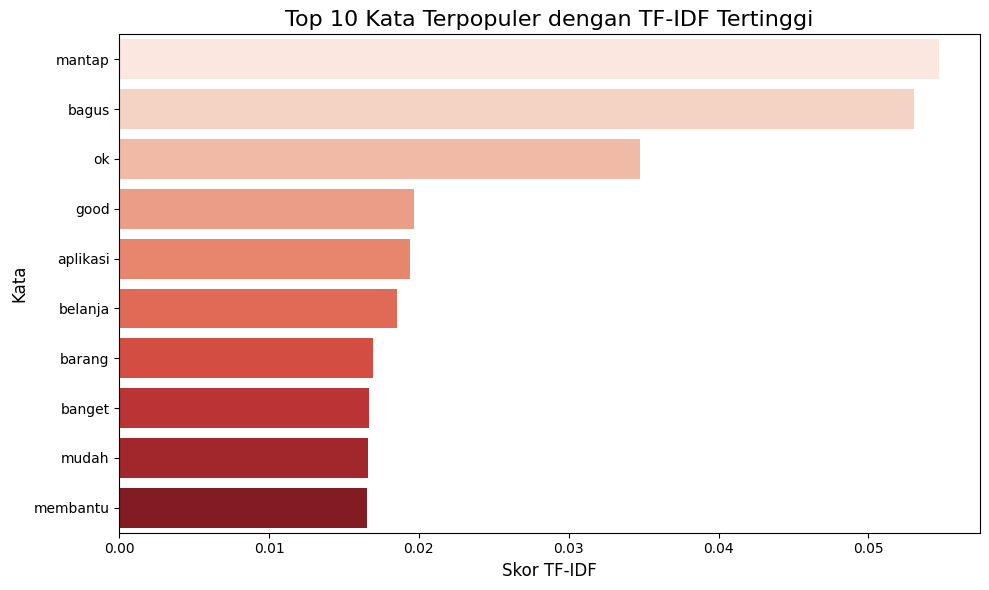

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Menggabungkan kembali token menjadi string karena TfidfVectorizer memerlukan input berupa teks
df['text_cleaned'] = df['text_stopword'].apply(' '.join)

# Menggunakan TfidfVectorizer untuk menghitung skor TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['text_cleaned'])
tfidf_scores = tfidf_matrix.mean(axis=0).A1
feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf_score': tfidf_scores})
top_10_tfidf = tfidf_df.sort_values(by='tfidf_score', ascending=False).head(10)


def plot_top_tfidf_words(top_tfidf):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_tfidf, x='tfidf_score', y='word', palette='Reds')
    plt.title('Top 10 Kata Terpopuler dengan TF-IDF Tertinggi', fontsize=16)
    plt.xlabel('Skor TF-IDF', fontsize=12)
    plt.ylabel('Kata', fontsize=12)
    plt.tight_layout()
    plt.show()

# Visualisasi Top 10 Kata
plot_top_tfidf_words(top_10_tfidf)


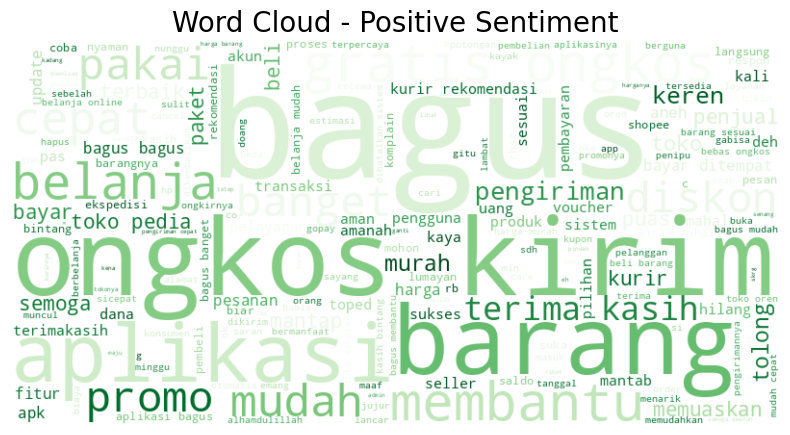

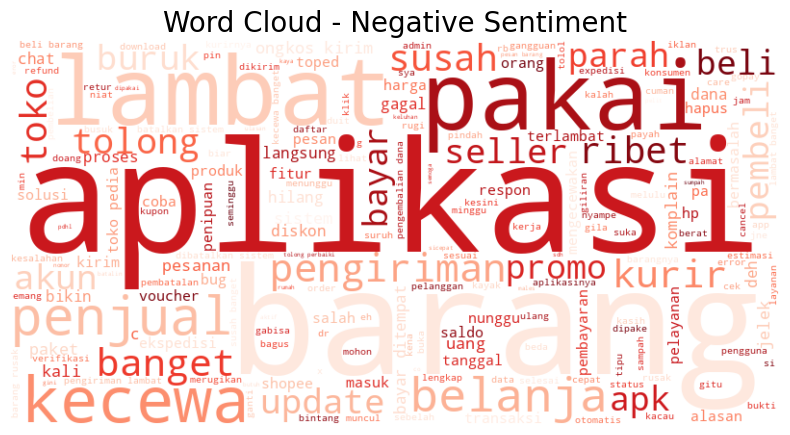

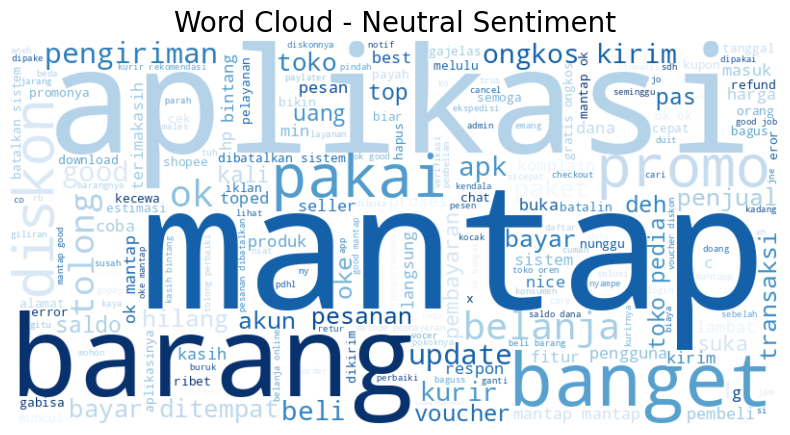

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Gabungkan teks berdasarkan kategori sentimen
positive_text = ' '.join(df[df['sentiment'] == 'positive']['text_stopword'].apply(lambda x: ' '.join(x)))
negative_text = ' '.join(df[df['sentiment'] == 'negative']['text_stopword'].apply(lambda x: ' '.join(x)))
neutral_text = ' '.join(df[df['sentiment'] == 'neutral']['text_stopword'].apply(lambda x: ' '.join(x)))

# Fungsi untuk membuat Word Cloud
def generate_wordcloud(text, title, color):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Generate Word Cloud untuk masing-masing sentimen
generate_wordcloud(positive_text, 'Word Cloud - Positive Sentiment', 'Greens')
generate_wordcloud(negative_text, 'Word Cloud - Negative Sentiment', 'Reds')
generate_wordcloud(neutral_text, 'Word Cloud - Neutral Sentiment', 'Blues')


# Data Preparetion

In [16]:
# ekstrak fitur dan label
X = df['clean_content']
y = df['sentiment'].map({'positive': 2, 'neutral': 1, 'negative': 0})

# Feature Engineering

In [17]:
# TF-IDF untuk Machine Learning
vectorizer = TfidfVectorizer(max_features=10000)
X_vectorized = vectorizer.fit_transform(X)

In [18]:
# Tokenisasi dan padding untuk LSTM (word ebbending)
# 1. Menginisialisasi Tokenizer
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)
# 2. Mengonversi teks menjadi sequences
X_sequences = tokenizer.texts_to_sequences(X)
# 3. Padding sequences untuk memastikan panjang sama
X_padded = pad_sequences(X_sequences, maxlen=100)

In [19]:
# Hitung jumlah kelas sentimen
num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")

# Tampilkan bentuk data fitur sequence
print(f"Feature sequence shape: {X_padded.shape}")

# Tampilkan ukuran vocabulary
word_index = tokenizer.word_index
print(f"Vocabulary size: {len(word_index)} words")


Number of classes: 3
Feature sequence shape: (19999, 100)
Vocabulary size: 12705 words


# Model Training dan Evaluasi

## LSTM (70/20/10)

In [20]:
# Membagi data menjadi training (70%), testing (20%), dan validation (10%)
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
    X_padded, y, test_size=0.2, random_state=42, stratify=y
)

X_train_lstm, X_val_lstm, y_train_lstm, y_val_lstm = train_test_split(
    X_train_lstm, y_train_lstm, test_size=0.125, random_state=42, stratify=y_train_lstm
)

# Menampilkan jumlah sampel pada masing-masing dataset
print("Total Samples:")
print(f"Training set: {X_train_lstm.shape[0]} samples")
print(f"Validation set: {X_val_lstm.shape[0]} samples")
print(f"Testing set: {X_test_lstm.shape[0]} samples")


Total Samples:
Training set: 13999 samples
Validation set: 2000 samples
Testing set: 4000 samples


In [21]:
# Initialize LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    SpatialDropout1D(0.4),
    LSTM(128, dropout=0.3, recurrent_dropout=0.3),
    Dense(3, activation='softmax')
])

# Compile the Model
lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# Train the Model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_val_lstm, y_val_lstm),
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


219/219 ━━━━━━━━━━━━━━━━━━━━ 74s 313ms/step - accuracy: 0.5943 - loss: 0.8255 - val_accuracy: 0.8640 - val_loss: 0.3470 - learning_rate: 0.0010
Epoch 2/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 334ms/step - accuracy: 0.8941 - loss: 0.2808 - val_accuracy: 0.9090 - val_loss: 0.2334 - learning_rate: 0.0010
Epoch 3/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 79s 321ms/step - accuracy: 0.9521 - loss: 0.1360 - val_accuracy: 0.9330 - val_loss: 0.2003 - learning_rate: 0.0010
Epoch 4/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 73s 332ms/step - accuracy: 0.9709 - loss: 0.0850 - val_accuracy: 0.9365 - val_loss: 0.1850 - learning_rate: 0.0010
Epoch 5/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 78s 314ms/step - accuracy: 0.9818 - loss: 0.0547 - val_accuracy: 0.9295 - val_loss: 0.1970 - learning_rate: 0.0010
Epoch 6/15
219/219 ━━━━━━━━━━━━━━━━━━━━ 85s 331ms/step - accuracy: 0.9876 - loss: 0.0412 - val_accuracy: 0.9370 - val_loss: 0.2008 - learning_rate: 0.0010


In [22]:
# Evaluasi Model LSTM
test_loss, test_accuracy = lstm_model.evaluate(X_test_lstm, y_test_lstm, verbose=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9245 - loss: 0.2285


In [23]:
# Ambil akurasi pelatihan dari epoch terakhir
akurasi_latih = history.history['accuracy'][-1]


Evaluasi Model LSTM:
Akurasi pelatihan: 0.9881
Akurasi pada data uji: 0.9320
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Negatif       0.91      0.88      0.89       678
      Netral       0.93      0.94      0.93      1894
     Positif       0.95      0.95      0.95      1428

    accuracy                           0.93      4000
   macro avg       0.93      0.92      0.93      4000
weighted avg       0.93      0.93      0.93      4000



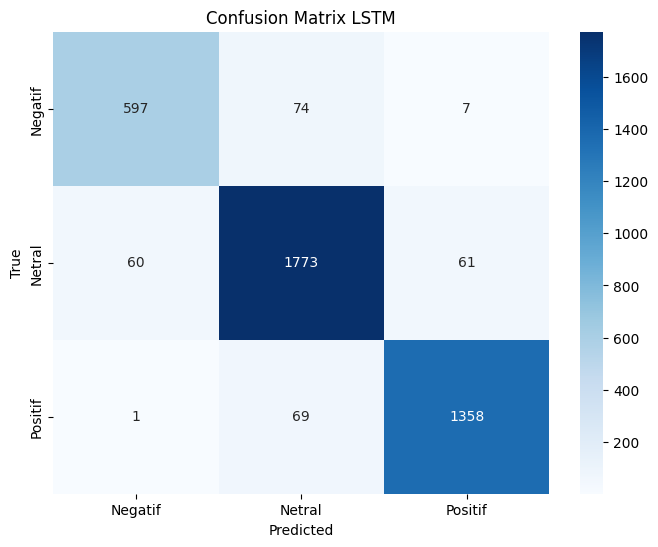

In [24]:
print("\nEvaluasi Model LSTM:")
print(f"Akurasi pelatihan: {akurasi_latih:.4f}")
print(f"Akurasi pada data uji: {test_accuracy:.4f}")

# Predict dan Laporan Klasifikasi
y_pred = lstm_model.predict(X_test_lstm, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nLaporan Klasifikasi:")
print(classification_report(
    y_test_lstm, y_pred_classes, target_names=['Negatif', 'Netral', 'Positif']
))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_lstm, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Netral', 'Positif'], yticklabels=['Negatif', 'Netral', 'Positif'])
plt.title("Confusion Matrix LSTM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

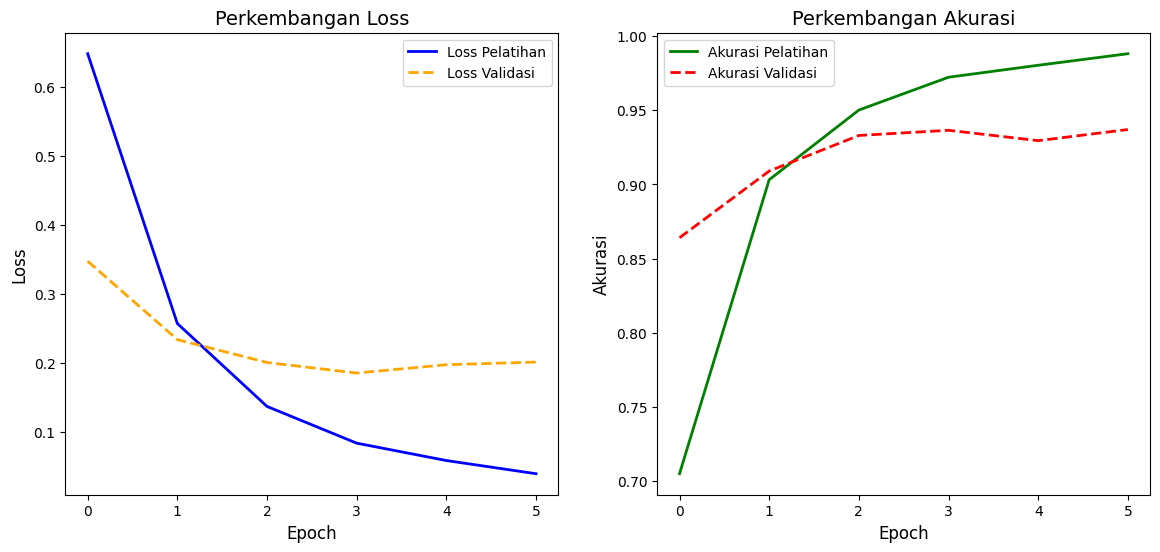

In [25]:
# Visualisasi performa pelatihan dan validasi
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafik loss pelatihan dan validasi
axes[0].plot(history.history['loss'], label='Loss Pelatihan', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Loss Validasi', color='orange', linestyle='--', linewidth=2)
axes[0].set_title('Perkembangan Loss', fontsize=14)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()

# Grafik akurasi pelatihan dan validasi
axes[1].plot(history.history['accuracy'], label='Akurasi Pelatihan', color='green', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Akurasi Validasi', color='red', linestyle='--', linewidth=2)
axes[1].set_title('Perkembangan Akurasi', fontsize=14)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Akurasi', fontsize=12)
axes[1].legend()

## Machine Learning

### SVM (80/20)

In [26]:
# Membagi Data Menjadi Data Latih dan Data Uji (80% latih, 20% uji)
X_latih_svm, X_uji_svm, y_latih_svm, y_uji_svm = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Menampilkan jumlah sampel pada masing-masing dataset
print("Jumlah Sampel:")
print(f"Data Latih: {X_latih_svm.shape[0]} sampel")
print(f"Data Uji: {X_uji_svm.shape[0]} sampel")


Jumlah Sampel:
Data Latih: 15999 sampel
Data Uji: 4000 sampel


In [27]:
# Inisialisasi model SVM dengan kernel linear
model_svm = SVC(kernel='linear', probability=True, random_state=42)
model_svm.fit(X_latih_svm, y_latih_svm)
y_pred_svm = model_svm.predict(X_uji_svm)

In [28]:
# Menghitung akurasi pada data latih dan data uji
akurasi_latih_svm = accuracy_score(y_latih_svm, model_svm.predict(X_latih_svm))
akurasi_uji_svm = accuracy_score(y_uji_svm, y_pred_svm)

print("\nEvaluasi Model SVM + TF-IDF")
print(f"Akurasi Data Latih: {akurasi_latih_svm:.4f}")
print(f"Akurasi Data Uji: {akurasi_uji_svm:.4f}")


Evaluasi Model SVM + TF-IDF
Akurasi Data Latih: 0.9694
Akurasi Data Uji: 0.9147



Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.90      0.79      0.84       739
     Neutral       0.88      0.95      0.92      1874
    Positive       0.97      0.93      0.95      1387

    accuracy                           0.91      4000
   macro avg       0.92      0.89      0.90      4000
weighted avg       0.92      0.91      0.91      4000



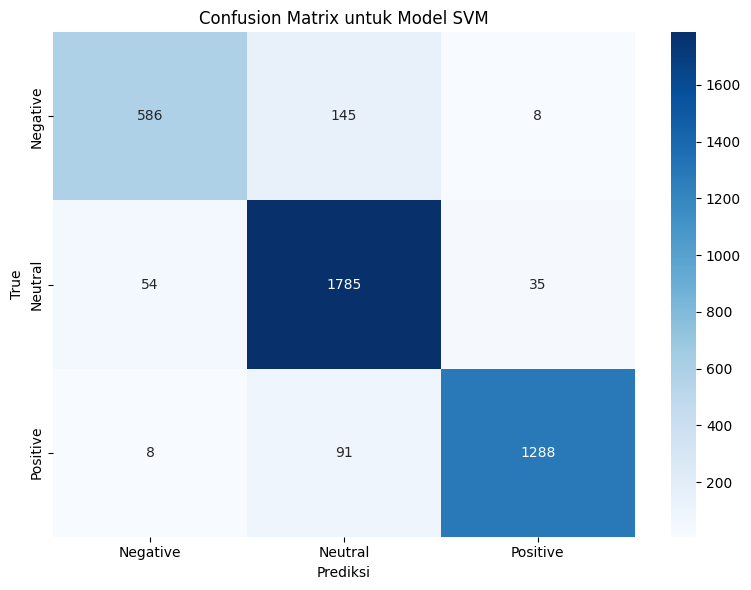

In [29]:
# Menampilkan laporan klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_svm, y_pred_svm, target_names=['Negative', 'Neutral', 'Positive']))

# Membuat confusion matrix
plt.figure(figsize=(8, 6))
matrix_konfusi = confusion_matrix(y_uji_svm, y_pred_svm)
sns.heatmap(matrix_konfusi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix untuk Model SVM')
plt.xlabel('Prediksi')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## Random Forest (70/30)

In [30]:
# Membagi Data Menjadi Data Latih dan Data Uji (70% latih, 30% uji)
X_latih_rf, X_uji_rf, y_latih_rf, y_uji_rf = train_test_split(X_vectorized, y, test_size=0.3, random_state=42)

# Menampilkan jumlah sampel pada masing-masing dataset
print("Jumlah Sampel:")
print(f"Data Latih: {X_latih_rf.shape[0]} sampel")
print(f"Data Uji: {X_uji_rf.shape[0]} sampel")


Jumlah Sampel:
Data Latih: 13999 sampel
Data Uji: 6000 sampel


In [31]:
# Inisialisasi model Random Forest
model_rf = RandomForestClassifier(random_state=42)
# Melatih model menggunakan data latih
model_rf.fit(X_latih_rf, y_latih_rf)
# Melakukan prediksi pada data uji
y_pred_rf = model_rf.predict(X_uji_rf)

In [32]:
# Menghitung akurasi pada data latih dan data uji
akurasi_latih_rf = accuracy_score(y_latih_rf, model_rf.predict(X_latih_rf))
akurasi_uji_rf = accuracy_score(y_uji_rf, y_pred_rf)

print("\nEvaluasi Model Random Forest + TF-IDF")
print(f"Akurasi Data Latih: {akurasi_latih_rf:.4f}")
print(f"Akurasi Data Uji: {akurasi_uji_rf:.4f}")


Evaluasi Model Random Forest + TF-IDF
Akurasi Data Latih: 0.9999
Akurasi Data Uji: 0.8630



Laporan Klasifikasi:
              precision    recall  f1-score   support

    Negative       0.81      0.73      0.76      1085
     Neutral       0.85      0.90      0.87      2820
    Positive       0.91      0.88      0.90      2095

    accuracy                           0.86      6000
   macro avg       0.86      0.84      0.84      6000
weighted avg       0.86      0.86      0.86      6000



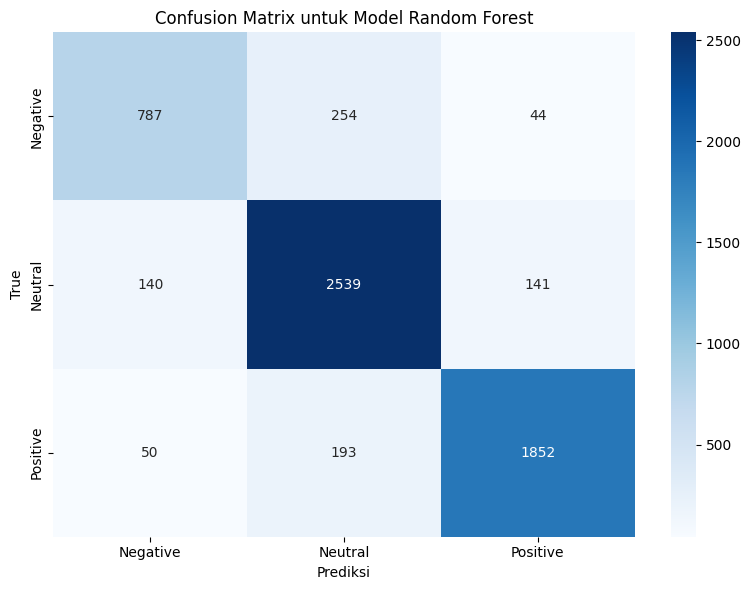

In [33]:
# Menampilkan laporan klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(y_uji_rf, y_pred_rf, target_names=['Negative', 'Neutral', 'Positive']))

# Membuat confusion matrix
plt.figure(figsize=(8, 6))
matrix_konfusi = confusion_matrix(y_uji_rf, y_pred_rf)
sns.heatmap(matrix_konfusi, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix untuk Model Random Forest')
plt.xlabel('Prediksi')
plt.ylabel('True')
plt.tight_layout()
plt.show()

## XGBost + TF IDF(70/30)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:49:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Evaluasi Model XGBoost + TF-IDF
Akurasi Data Latih: 0.9324
Akurasi Data Uji: 0.8695

Laporan Klasifikasi untuk XGBoost:
              precision    recall  f1-score   support

    Negative       0.83      0.74      0.78      1085
     Neutral       0.85      0.91      0.88      2820
    Positive       0.92      0.88      0.90      2095

    accuracy                           0.87      6000
   macro avg       0.87      0.84      0.85      6000
weighted avg       0.87      0.87      0.87      6000



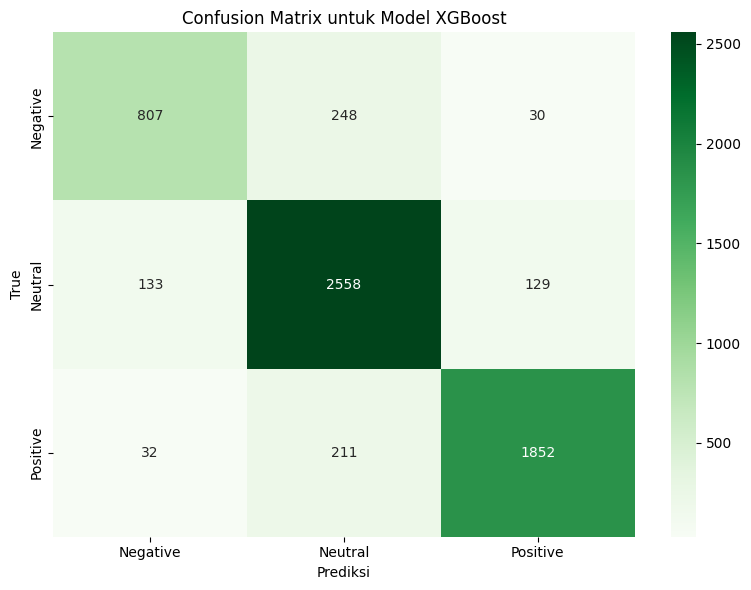

In [34]:
from xgboost import XGBClassifier
# Inisialisasi model XGBoost
model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Melatih model menggunakan data latih
X_latih_xgb, X_uji_xgb, y_latih_xgb, y_uji_xgb = train_test_split(X_vectorized, y, test_size=0.3, random_state=42)
model_xgb.fit(X_latih_xgb, y_latih_xgb)

# Melakukan prediksi pada data uji
y_pred_xgb = model_xgb.predict(X_uji_xgb)

# Evaluasi model XGBoost
akurasi_latih_xgb = accuracy_score(y_latih_xgb, model_xgb.predict(X_latih_xgb))
akurasi_uji_xgb = accuracy_score(y_uji_xgb, y_pred_xgb)

print("\nEvaluasi Model XGBoost + TF-IDF")
print(f"Akurasi Data Latih: {akurasi_latih_xgb:.4f}")
print(f"Akurasi Data Uji: {akurasi_uji_xgb:.4f}")

# Menampilkan laporan klasifikasi untuk XGBoost
print("\nLaporan Klasifikasi untuk XGBoost:")
print(classification_report(y_uji_xgb, y_pred_xgb, target_names=['Negative', 'Neutral', 'Positive']))

# Membuat confusion matrix untuk XGBoost
plt.figure(figsize=(8, 6))
matrix_konfusi_xgb = confusion_matrix(y_uji_xgb, y_pred_xgb)
sns.heatmap(matrix_konfusi_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix untuk Model XGBoost')
plt.xlabel('Prediksi')
plt.ylabel('True')
plt.tight_layout()
plt.show()



Tabel Perbandingan Model:
                            Model  Akurasi Training  Akurasi Testing
0        XGBoost + TF-IDF (70/30)          0.932424          0.86950
1            SVM + TF-IDF (70/30)          0.969373          0.91475
2  Random Forest + TF-IDF (70/30)          0.999857          0.86300
3   LSTM + Word Embedding (70/30)          0.988142          0.93200


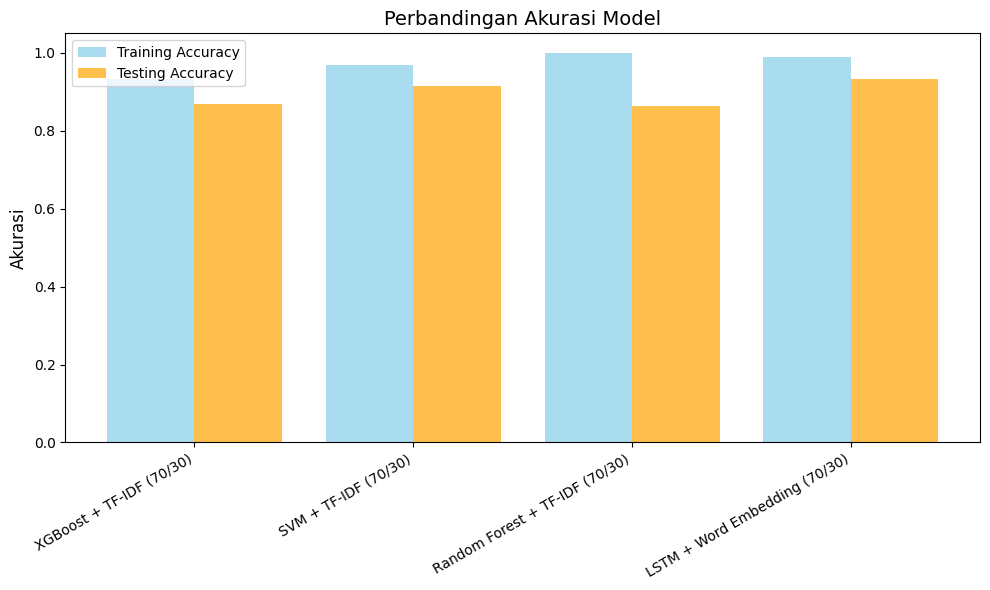

In [35]:
# Inisialisasi dictionary untuk menyimpan hasil model
model_results = {
    'Model': [],
    'Akurasi Training': [],
    'Akurasi Testing': []
}

# Fungsi untuk menambahkan hasil model ke model_results
def update_model_results(name, train_accuracy, test_accuracy):
    if name not in model_results.get('Model', []):
        model_results['Model'].append(name)
        model_results['Akurasi Training'].append(train_accuracy)
        model_results['Akurasi Testing'].append(test_accuracy)

# Tambahkan hasil XGBoost
update_model_results('XGBoost + TF-IDF (70/30)', akurasi_latih_xgb, akurasi_uji_xgb)

# Tambahkan hasil SVM
update_model_results('SVM + TF-IDF (70/30)', akurasi_latih_svm, akurasi_uji_svm)

# Tambahkan hasil Random Forest
update_model_results('Random Forest + TF-IDF (70/30)', akurasi_latih_rf, akurasi_uji_rf)

# Tambahkan hasil LSTM
update_model_results('LSTM + Word Embedding (70/30)', akurasi_latih, test_accuracy)

# Perbarui DataFrame
df_comparison = pd.DataFrame(model_results).drop_duplicates()

# Tampilkan tabel perbandingan
print("\nTabel Perbandingan Model:")
print(df_comparison)

# Visualisasi hasil dengan plot
plt.figure(figsize=(10, 6))
x = df_comparison['Model']
training_accuracies = df_comparison['Akurasi Training']
testing_accuracies = df_comparison['Akurasi Testing']

bar_width = 0.4
x_indexes = range(len(x))

plt.bar(
    [i - bar_width / 2 for i in x_indexes], training_accuracies,
    width=bar_width, color='skyblue', label='Training Accuracy', alpha=0.7
)
plt.bar(
    [i + bar_width / 2 for i in x_indexes], testing_accuracies,
    width=bar_width, color='orange', label='Testing Accuracy', alpha=0.7
)

plt.title('Perbandingan Akurasi Model', fontsize=14)
plt.ylabel('Akurasi', fontsize=12)
plt.xticks(ticks=x_indexes, labels=x, rotation=30, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


# Interpretasi dan Kesimpulan

- Melalui analisis sentimen ini, dapat diketahui bahwa sentimen terkait pengguna aplikasi belanja online Tokopedia didominasi sentimen netral.
- melalui 4 pelatihan dan pengujian model, metode Random menjadi metode dengan akurasi terbaik pada training namun memiliki akurasi terendah kedua diantara model lainnya pada data testing.
- LSTM unggul baik pada akurasi testing maupun training sehingga dapat disimpulkan bila metode LSTM cocok untuk memprediksi kelas pada kasus ini.
- Melalui 2 eksperimen pembagian data, spliting terbaik untuk menghasilkan akurasi minimal 92% ada pada rasio 80:20.
- Dapat dilakukan tuning parameter, augmentasi data, SMOTE, dan beberapa eksperimen untuk splitting data yang nantinya dapat ditinjau kembali mana model yang terbaik.
- Bila menggunakan fitur TF-IDF, Model SVM memiliki kemampuan baik untuk melakukan prediksi pada data testing.


In [36]:
lstm_model.save('lstm_sentiment_model.h5')
print("Model LSTM berhasil disimpan ke file 'lstm_sentiment_model.h5'.")

Model LSTM berhasil disimpan ke file 'lstm_sentiment_model.h5'.


# Interference

# Interference dengan Model Terbaik

In [37]:
import pickle
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

In [38]:
# Simpan tokenizer ke file
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Tokenizer berhasil disimpan.")

Tokenizer berhasil disimpan.


In [39]:
# Load Model LSTM
lstm_model = tf.keras.models.load_model("lstm_sentiment_model.h5")

In [43]:
# Memuat tokenizer dari file
with open('tokenizer.pkl', 'rb') as file:
    tokenizer_loaded = pickle.load(file)
print("Tokenizer berhasil dimuat.")

Tokenizer berhasil dimuat.


In [57]:
# New Sample Data for Prediction
new_texts = [
    "Produk ini cocok",
    "Kurang sekali untuk pelayanannya sangat lambat ",
    "Biasa saja."
]

# Preprocessing for LSTM Model
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=100)

In [58]:
# Predict with LSTM
lstm_preds = np.argmax(lstm_model.predict(new_padded), axis=1)
# Displaying the Prediction Results
label_map = {0: "negative", 1: "neutral", 2: "positive"}

print("\nSentiment Prediction Results: ")
for i, text in enumerate(new_texts):
    print(f"Text: {text}")
    print(f"Prediction: {label_map[lstm_preds[i]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Sentiment Prediction Results: 
Text: Produk ini cocok
Prediction: positive
Text: Kurang sekali untuk pelayanannya sangat lambat 
Prediction: negative
Text: Biasa saja.
Prediction: neutral
